# Code Appendix
for CS194 Project: Autism Risk Genes Across the Genome
Ivan Kristanto, Vivian Lu, Stefan Bielmeier

## Setup

In [ ]:
# Download data files from paper's repo at https://github.com/ShenLab/A-risk/tree/master/data
DO_DOWNLOAD_FILES = True

if DO_DOWNLOAD_FILES:
  !wget --quiet https://raw.githubusercontent.com/ShenLab/A-risk/master/data/celltype%3E10cells_fraction_LM_noUnk.csv 
  !wget --quiet https://raw.githubusercontent.com/ShenLab/A-risk/master/data/celltype%3E10cells_fraction_zhong.csv
  !wget --quiet https://raw.githubusercontent.com/ShenLab/A-risk/master/data/control_genes_1911_iossifov.csv
  !wget --quiet https://raw.githubusercontent.com/ShenLab/A-risk/master/data/fraction_expression_Hodge2019.csv
  !wget --quiet https://raw.githubusercontent.com/ShenLab/A-risk/master/data/sfari_high_confidence_genes_08292019.csv

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tqdm import tqdm

# Models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, r2_score

# Misc
from sklearn.model_selection import StratifiedKFold
from scipy import interpolate
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV

## Reproducing The Paper

### Data Pre-Processing

In [ ]:
# Loading and merging the X Data
lm = pd.read_csv('celltype>10cells_fraction_LM_noUnk.csv', index_col=0) 
zhong = pd.read_csv("celltype>10cells_fraction_zhong.csv", index_col=0)

print(f'Shape of lm data: {lm.shape}')
print(f'Shape of zhong data: {zhong.shape}')

all_genes = pd.merge(lm, zhong, left_index=True, right_index=True, how='inner')
print(f'Shape of merged feature matrix: {all_genes.shape}')

all_genes.head()

Shape of lm data: (19531, 47)
Shape of zhong data: (24153, 48)
Shape of merged feature matrix: (17740, 95)


,hRgl2a_7,hProgBP_7,hOMTN_7,hRgl2a_9,hNProg_9,hProgBP_9,hOMTN_9,hDA0_9,hNbM_9,hNbML5_9,hDA1_9,hGaba_9,hDA2_9,hNbGaba_9,hRgl2a_10,hDA0_10,hNbM_10,hEndo_10,hRgl2b_10,hRgl3_10,hPeric_10,hDA1_10,hRgl1_10,hDA2_10,hRgl2a_11,hEndo_11,hRgl2b_11,hRgl3_11,hPeric_11,hRgl2c_11,hOPC_11,hNProg_6,hProgBP_6,hProgM_6,hOMTN_6,hProgFPL_6,hProgFPM_6,hNbML1_6,hNProg_8,hProgBP_8,...,OPCs_2_GW23,exneurons_5_GW19,exneurons_6_GW19,exneurons_7_GW19,astrocytes_1_GW26,astrocytes_3_GW26,exneurons_5_GW26,exneurons_6_GW26,exneurons_7_GW26,interneurons_5_GW26,interneurons_6_GW26,interneurons_2_GW26,interneurons_4_GW26,interneurons_7_GW26,interneurons_8_GW26,microglia_2_GW26,OPCs_2_GW26,OPCs_3_GW26,OPCs_1_GW26,exneurons_1_GW8,exneurons_1_GW10,NPCs_6_GW10,NPCs_1_GW10,NPCs_5_GW10,exneurons_2_GW12,exneurons_1_GW9,NPCs_1_GW9,exneurons_5_GW16,exneurons_4_GW16,exneurons_3_GW16,interneurons_6_GW16,interneurons_2_GW16,interneurons_7_GW16,interneurons_8_GW16,NPCs_3_GW16,NPCs_6_GW16,NPCs_8_GW16,NPCs_7_GW16,NPCs_9_GW16,OPCs_2_GW16
DDX11L1,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,0.047619,0.066667,0.000000,0.000000,0.000000,0.043478,0.000000,0.000,0.01,0.0000,0.000000,0.000000,0.000000,0.000000,0.017391,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.00,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
LOC101928626,0.000000,0.0625,0.058824,0.0,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.076923,0.043478,0.000000,0.000,0.05,0.0000,0.000000,0.083333,0.111111,0.095238,0.165217,0.111111,0.117647,0.047619,0.0375,0.046512,0.062500,0.12,0.140845,0.10,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.03125,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
LINC00115,0.000000,0.0000,0.058824,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000,0.02,0.0625,0.105263,0.000000,0.055556,0.095238,0.008696,0.055556,0.058824,0.047619,0.0375,0.069767,0.083333,0.08,0.056338,0.05,0.190476,0.037037,0.043478,0.027027,0.115385,0.029412,0.017544,0.083333,0.069767,0.00000,...,0.181818,0.000000,0.000000,0.029412,0.184211,0.1250,0.000000,0.133333,0.057692,0.000000,0.00,0.058824,0.026316,0.025,0.101449,0.055556,0.066667,0.000000,0.157895,0.142857,0.056180,0.000000,0.00,0.046512,0.056604,0.029412,0.00,0.079812,0.102857,0.117241,0.058824,0.000000,0.0625,0.055556,0.121212,0.10,0.058824,0.272727,0.111111,0.000000
LINC01128,0.058824,0.1875,0.117647,0.0,0.076923,0.111111,0.238095,0.066667,0.333333,0.172414,0.230769,0.152174,0.083333,0.125,0.07,0.0625,0.263158,0.166667,0.055556,0.000000,0.130435,0.055556,0.058824,0.000000,0.0875,0.116279,0.145833,0.20,0.211268,0.15,0.047619,0.037037,0.130435,0.135135,0.192308,0.058824,0.035088,0.083333,0.093023,0.12500,...,0.090909,0.250000,0.259259,0.147059,0.263158,0.4375,0.214286,0.177778,0.115385,0.083333,0.04,0.058824,0.157895,0.225,0.386473,0.222222,0.233333,0.133333,0.263158,0.285714,0.235955,0.333333,0.25,0.302326,0.132075,0.205882,0.08,0.206573,0.297143,0.358621,0.176471,0.416667,0.1875,0.333333,0.363636,0.15,0.352941,0.500000,0.296296,0.166667
FAM41C,0.000000,0.0000,0.000000,0.0,0.076923,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000,0.00,0.0625,0.000000,0.000000,0.055556,0.000000,0.008696,0.055556,0.000000,0.000000,0.0250,0.000000,0.000000,0.00,0.014085,0.00,0.000000,

In [ ]:
# Loading and preprocessing Y Data 
autism_data = pd.read_csv("sfari_high_confidence_genes_08292019.csv", index_col=0) #known disease causing
control_data = pd.read_csv("control_genes_1911_iossifov.csv", index_col=0) #known negative

# Showing dimensions of known and known negative
print(f'Shape of Known Autism-causing Genes data: {autism_data.shape}')
print(f'Shape of control-genes: {control_data.shape}')

# Filter to get the y_pos and y_neg (training data precursor)
y_pos = all_genes.loc[all_genes.index.intersection(autism_data['gene.symbol']),]
y_neg = all_genes.loc[all_genes.index.intersection(control_data['GeneName']), ]

# Make sure there is no overlap of genes in y_pos and y_neg
y_neg = y_neg.drop(index=y_pos.index.intersection(y_neg.index))

# Add 'labels' column
y_pos['label'] = 1
y_neg['label'] = 0

# Report shapes
print(f'Shape of y_pos: {y_pos.shape}')
print(f'Shape of y_neg: {y_neg.shape}')

Shape of Known Autism-causing Genes data: (91, 7)
Shape of control-genes: (174, 5)
Shape of y_pos: (88, 96)
Shape of y_neg: (154, 96)


In [ ]:
# Construct Training Set
train = pd.concat([y_pos, y_neg])
y_train = train['label']
X_train = train.drop(columns='label')

# Report shapes
print(f'The training set consists of: \n - {train.shape[0]} samples (genes) <- {y_pos.shape[0]} positives and {y_neg.shape[0]} negatives, \n - {X_train.shape[1]} features (expression by cell type*time)')

# preview 
train[['label', *train.columns]].head()

The training set consists of: 
 - 242 samples (genes) <- 88 positives and 154 negatives, 
 - 95 features (expression by cell type*time)


,label,hRgl2a_7,hProgBP_7,hOMTN_7,hRgl2a_9,hNProg_9,hProgBP_9,hOMTN_9,hDA0_9,hNbM_9,hNbML5_9,hDA1_9,hGaba_9,hDA2_9,hNbGaba_9,hRgl2a_10,hDA0_10,hNbM_10,hEndo_10,hRgl2b_10,hRgl3_10,hPeric_10,hDA1_10,hRgl1_10,hDA2_10,hRgl2a_11,hEndo_11,hRgl2b_11,hRgl3_11,hPeric_11,hRgl2c_11,hOPC_11,hNProg_6,hProgBP_6,hProgM_6,hOMTN_6,hProgFPL_6,hProgFPM_6,hNbML1_6,hNProg_8,...,exneurons_5_GW19,exneurons_6_GW19,exneurons_7_GW19,astrocytes_1_GW26,astrocytes_3_GW26,exneurons_5_GW26,exneurons_6_GW26,exneurons_7_GW26,interneurons_5_GW26,interneurons_6_GW26,interneurons_2_GW26,interneurons_4_GW26,interneurons_7_GW26,interneurons_8_GW26,microglia_2_GW26,OPCs_2_GW26,OPCs_3_GW26,OPCs_1_GW26,exneurons_1_GW8,exneurons_1_GW10,NPCs_6_GW10,NPCs_1_GW10,NPCs_5_GW10,exneurons_2_GW12,exneurons_1_GW9,NPCs_1_GW9,exneurons_5_GW16,exneurons_4_GW16,exneurons_3_GW16,interneurons_6_GW16,interneurons_2_GW16,interneurons_7_GW16,interneurons_8_GW16,NPCs_3_GW16,NPCs_6_GW16,NPCs_8_GW16,NPCs_7_GW16,NPCs_9_GW16,OPCs_2_GW16,label
SRSF11,1,0.705882,0.5625,0.705882,0.769231,0.846154,0.666667,0.904762,0.733333,0.916667,0.793103,0.923077,0.739130,0.416667,0.8125,0.72,0.6875,0.684211,0.666667,0.611111,0.571429,0.686957,0.666667,0.764706,0.714286,0.7875,0.697674,0.708333,0.84,0.647887,0.75,0.666667,0.629630,0.608696,0.756757,0.807692,0.823529,0.614035,0.500000,0.558140,...,0.833333,0.888889,0.764706,0.921053,1.0000,1.000000,0.800000,0.730769,0.708333,0.60,0.529412,0.789474,0.8375,0.869565,0.777778,0.8,0.733333,1.000000,0.928571,0.921348,1.000000,1.000000,0.976744,0.773585,0.911765,0.96,0.877934,0.937143,0.965517,0.882353,0.833333,0.9375,0.833333,1.000000,0.95,0.882353,1.000000,0.925926,0.916667,1
POGZ,1,0.235294,0.3750,0.470588,0.384615,0.384615,0.444444,0.571429,0.400000,0.500000,0.275862,0.461538,0.608696,0.416667,0.4375,0.48,0.3750,0.421053,0.291667,0.611111,0.476190,0.400000,0.611111,0.352941,0.476190,0.4500,0.302326,0.479167,0.52,0.408451,0.45,0.333333,0.333333,0.413043,0.486486,0.653846,0.735294,0.473684,0.166667,0.418605,...,0.666667,0.703704,0.588235,0.736842,0.8125,0.500000,0.600000,0.576923,0.458333,0.48,0.411765,0.315789,0.7625,0.705314,0.388889,0.7,0.533333,0.736842,0.571429,0.674157,0.666667,0.333333,0.813953,0.641509,0.617647,0.76,0.652582,0.737143,0.820690,0.235294,0.666667,0.8125,0.722222,0.666667,0.70,0.823529,0.909091,0.629630,0.583333,1
ILF2,1,1.000000,0.9375,0.764706,0.615385,0.692308,0.722222,0.857143,0.200000,0.500000,0.517241,0.769231,0.456522,0.333333,0.5625,0.70,0.6250,0.684211,0.750000,0.777778,0.619048,0.582609,0.666667,0.470588,0.761905,0.6625,0.488372,0.500000,0.72,0.605634,0.70,0.523810,0.740741,0.913043,0.837838,0.961538,0.941176,0.877193,0.750000,0.767442,...,1.000000,1.000000,0.941176,0.947368,1.0000,0.857143,0.933333,0.865385,0.833333,0.72,0.647059,0.763158,0.8750,0.884058,1.000000,0.9,0.866667,1.000000,1.000000,0.988764,0.916667,1.000000,0.953488,0.943396,1.000000,1.00,0.990610,0.988571,1.000000,0.941176,0.916667,1.0000,1.000000,1.000000,0.95,1.000000,1.000000,1.000000,0.916667,1
ASH1L,1,0.235294,0.2500,0.352941,0.461538,0.461538,0.166667,0.428571,0.333333,0.416667,0.448276,0.538462,0.521739,0.416667,0.5000,0.64,0.5000,0.421053,0.583333,0.666667,0.619048,0.556522,0.611111,0.529412,0.380952,0.5125,0.441860,0.333333,0.52,0.450704,0.55,0.523810,0.370370,0.478261,0.540541,0.615385,0.294118,0.438596,0.250000,0.325581,...,0.583333,0.518519,0.470588,0.578947,0.8125,0.571429,0.466667,0.500000,0.375000,0.56,0.588235,0.421053,0.7000,0.700483,0.611111,0.5,0.466667,0.947368,0.357143,0.483146,0.583333,0.583333,0.651163,0.433962,0.558824,0.52,0.497653,0.651429,0.662069,0.411765,0.500000,0.6250,0.611111,0.696970,0.55,0.647059,0.818182,0.481481,0.750000,1
KDM5B,1,0.529412,0.1875,0.352941,0.615385,0.461538,0.222222,0.714286,0.466667,0.750000,0.551724,0.615385,0.500000,0.333333,0.5000,0.38,0.3750,0.473684,0.250000,0.611111,0.428571,0.356522,0.444444,0.235294,0.285714,0.3625,0.418605,0.229167,0.24,0.197183,0.15,0.285714,0.259259,0.369565,0.378378,0.423077,0.500000,0.40

In [ ]:
# Construct Test Data (but no labels)
X_test = all_genes.drop(index=train.index)
X_test.shape

(17498, 95)

### Model Training and Pre-Evaluation
We will train the model using a stratified 5-fold cross validation, which maintains the response distribution in every split. Since evaluation is done by calculating enrichment, we will instead do pre-evaluation using averaged 5-fold validation metrics.

The following framework is made to be generalizable to other sklearn models.

In [ ]:
# Helper class to plot
class ROCPlotter:
  def __init__(self, figsize: tuple=(7, 5)):
    self.tprs = []
    self.aucs = []
    self.fold_i = 0
    self.mean_fpr = np.linspace(0, 1, 100)

    # set fig
    plt.figure(figsize=figsize, dpi=80)
    plt.clf()

  def add_batch(self, y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)

    # ROC Plot Coords
    interped = interpolate.interp1d(fpr, tpr)(self.mean_fpr)
    self.tprs.append(interped)
    self.tprs[-1][0] = 0.0

    # AUC Score
    roc_auc = auc(fpr, tpr)
    self.aucs.append(roc_auc)

    # Plot
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
              label='ROC fold %d (AUC = %0.2f)' % (self.fold_i, roc_auc))
  
    self.fold_i += 1

    return 

  def compute(
      self, 
      modelname='Model',
  ):
    # Baseline
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         alpha=.8)
    
    # Aggregate Metrics
    mean_tpr = np.mean(self.tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(self.mean_fpr, mean_tpr)
    std_auc = np.std(self.aucs)

    plt.plot(self.mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(self.tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(self.mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve of Stratified {self.fold_i}-fold CV for {modelname}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
    return

In [ ]:
class Trainer:
  def __init__(
    self, 
    model, 
    N_SPLITS=5,
    X_train=X_train, 
    y_train=y_train,
    X_test=all_genes
  ):
    self.N_SPLITS = N_SPLITS
    self.model = model
    self.X_train=X_train
    self.y_train=y_train
    self.X_test=X_test

  def do_train(self) -> None:
    # Train initial model
    clf = self.model.fit(self.X_train, self.y_train)

    # Instantiate Stuff
    skf = StratifiedKFold(n_splits=self.N_SPLITS, shuffle=True)
    plotter = ROCPlotter()

    # Tracking Variables
    i = 0
    self.risk_pred_cv = np.zeros((self.X_test.shape[0], self.N_SPLITS))
    self.feature_imp_cv =  np.zeros((self.X_test.shape[1], self.N_SPLITS))

    # Main Loop
    with tqdm(total=self.N_SPLITS) as pbar:
      pbar.set_description(f'Doing {clf.__class__.__name__}')
      for train_idx, test_idx in skf.split(self.X_train, self.y_train):
        # Get datasets
        X_val_train = self.X_train.iloc[train_idx]
        y_val_train = self.y_train.iloc[train_idx]
        X_val_test = self.X_train.iloc[test_idx]
        y_val_test = self.y_train.iloc[test_idx]

        # Fit and Predict
        clf_val = sklearn.base.clone(clf).fit(X_val_train, y_val_train)
        y_probs = clf_val.predict_proba(X_val_test)

        # Plot ROC
        plotter.add_batch(y_val_test, y_probs[:, 1])

        # Update Tracking Variables
        y_test_probs = clf_val.predict_proba(self.X_test)
        self.risk_pred_cv[:, i] = y_test_probs[:, 1]
        self.feature_imp_cv[:, i] = clf_val.feature_importances_

        pbar.update(1)
        i += 1

    plotter.compute(modelname=clf.__class__.__name__)
    
  def _predict_feature_importance(self, feature_importance):
    sorted_idx = (-feature_importance).argsort() # sort descending
    sorted_idx = sorted_idx[np.array(feature_importance[sorted_idx] != 0)] # only nonzeros
    self.X_test.columns[sorted_idx]

    out = pd.DataFrame()
    out['Cell Type'] = self.X_test.columns[sorted_idx]
    out['Importance'] = feature_importance[sorted_idx]
    out['Rank'] = list(range(1, out.shape[0]+1))

    return out

  def _predict_risk_scores(self, risk_scores):
    out = pd.DataFrame()
    out['Risk'] = risk_scores
    out['Batch'] = 'testing'
    out.index = self.X_test.index

    # Get Indices
    pos_idx = self.X_train.loc[self.y_train == 1].index
    neg_idx = self.X_train.loc[self.y_train == 0].index

    # Rename Batches
    out.loc[pos_idx, 'Batch'] = 'autism'
    out.loc[neg_idx, 'Batch'] = 'control'

    # Rank
    out['Rank'] = out['Risk'].rank(ascending=False)

    return out

  def predict_cv(self):
    """ Output predictions *averaged* over K-fold CV.
    """
    # Feature Importance
    avg_feature_importance = np.mean(self.feature_imp_cv, axis=1)
    out_feat_imp = self._predict_feature_importance(avg_feature_importance)

    # Risk Scores
    avg_risk_scores = np.mean(self.risk_pred_cv, axis=1)
    out_risk_scores = self._predict_risk_scores(avg_risk_scores)

    return out_feat_imp, out_risk_scores

  def predict(self):
    """ Output predictions of model trained on *full* dataset.
    """
    # Feature Importance
    pred_feature_importance = self.model.feature_importances_
    out_feat_imp = self._predict_feature_importance(pred_feature_importance)

    # Risk Scores
    pred_risk_scores = self.model.predict_proba(self.X_test)[:, 1]
    out_risk_scores = self._predict_risk_scores(pred_risk_scores)

    return out_feat_imp, out_risk_scores

Doing GradientBoostingClassifier: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


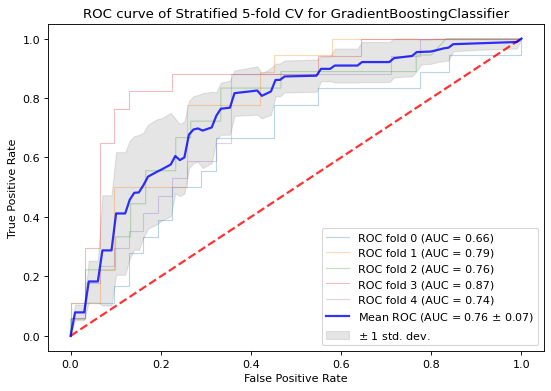

In [ ]:
params = {
  'n_estimators': 300,
  'learning_rate': 0.05, 
  'max_depth': 1, 
  'random_state': 7
}

gbc_trainer = Trainer(
  model=GradientBoostingClassifier(**params),
  X_train=X_train, 
  y_train=y_train,
  X_test=all_genes
)
gbc_trainer.do_train()
gbc_feats_cv, gbc_risk_cv = gbc_trainer.predict_cv()
gbc_feats, gbc_risk = gbc_trainer.predict()

## Model Evaluation - Versus Author Data

Right now, we have two types of outputs: CV-averaged and model trained on full dataset. The authors did CV-averaged outputs, so here I will do that first (compare my CV-avg vs their CV-avg). Then I will try the full model and see how it differs from the authors' outcomes.

First of all, the most important cell types reported by the authors are NOT the same as the one I got when I ran their notebook verbatim. They did not set a seed, so the results actually vary. I am loading the data that is produced when I ran it, not what they had on the paper, since I can't get access to this.

Note that correlation is NOT a measure of performance. We are not assuming that the original results are the best results. It just tells us how SIMILAR our model is to the original, for better or worse.

In [ ]:
# Collecting top 30 cell types (feature importance) in authors' results
baseline_feature_importance = pd.read_csv('https://github.com/ivalexander13/cs194-project/raw/main/feature_importance_filteredCellNumber_LMZhong_fracE_filtergene_zhong_classifier_average_noUnk_08292019sfari.csv', index_col=0)

baseline_feature_importance['Rank'] = baseline_feature_importance['importance'].rank(ascending=False)
baseline_feature_importance.set_index('celltypes', inplace=True)
baseline_feature_importance.sort_values(by='Rank', inplace=True)
baseline_feature_importance.rename(columns={'importance': "Importance"}, inplace=True)
baseline_feature_importance.head()

,Importance,Rank
celltypes,,
hGaba_9,0.343817,1.0
hNbGaba_9,0.154181,2.0
hRgl2a_9,0.058088,3.0
hDA1_10,0.047735,4.0
hOMTN_9,0.035896,5.0


In [ ]:
# Helper plotter
def plot_compare_baseline(
    data, 
    baseline_colname='Importance_baseline', 
    pred_colname='Importance',
    log_scales=True,
    alpha=1
    ):
  x = data[baseline_colname]
  y = data[pred_colname]

  maxx = max(*x, *y) * 1.5
  minn = min(np.array([*x, *y])[np.array([*x, *y]) > 0]) * 0.5

  plt.scatter(x, y, alpha=alpha)
  plt.xlim([minn, maxx])
  plt.ylim([minn, maxx])
  if log_scales:
    plt.yscale('log')
    plt.xscale('log')
  plt.title(f'Predicted vs Authors\' {pred_colname}')
  plt.ylabel(f'Predicted {pred_colname}')
  plt.xlabel(f'Baseline (Authors\') {pred_colname}')
  plt.tight_layout()
  plt.show()

  print(f'R2: {r2_score(x, y)}')

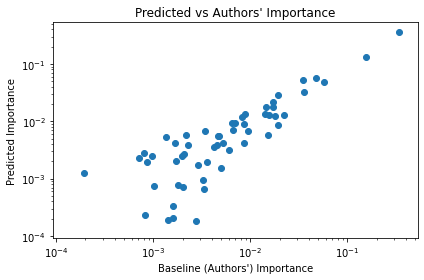

R2: 0.9882499794990173


In [ ]:
# Compare Feature Importance for CV-avg GBC model
feats__gbc_cv_combined_baseline = pd.merge(
    gbc_feats_cv, 
    baseline_feature_importance, 
    how='inner', 
    left_on='Cell Type', 
    right_index=True,
    suffixes=('', '_baseline')
    )

plot_compare_baseline(data=feats__gbc_cv_combined_baseline)

Now I am trying using the FULL MODEL vs author's CV_avg. 

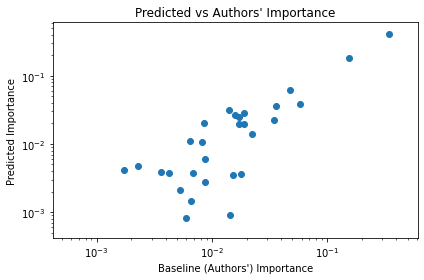

R2: 0.9431166435108077


In [ ]:
# Compare Feature Importance for full GBC model

feats__gbc_combined_baseline = pd.merge(
    gbc_feats, 
    baseline_feature_importance, 
    how='inner', 
    left_on='Cell Type', 
    right_index=True,
    suffixes=('', '_baseline')
    )

plot_compare_baseline(data=feats__gbc_combined_baseline)

Now doing the same for Risk scores

In [ ]:
baseline_risk_scores = pd.read_csv('https://github.com/ivalexander13/cs194-project/raw/main/prediction_allGenes_GBT_filteredCellNumber_LMZhong_fracE_classifier_average_noUnk_08292019sfari.csv', index_col=0)
baseline_risk_scores.head()

,Frisk,Batch
DDX11L1,0.065435,testing
LOC101928626,0.107505,testing
LINC00115,0.108803,testing
LINC01128,0.232370,testing
FAM41C,0.126594,testing


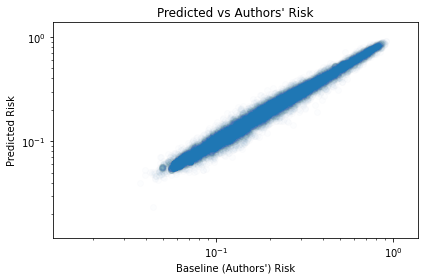

R2: 0.9816983533696372


In [ ]:
# Compare Risk Scores for CV-avg GBC model
risk__gbc_cv_combined_baseline = pd.merge(
    gbc_risk_cv, 
    baseline_risk_scores, 
    how='inner', 
    left_index=True, 
    right_index=True,
    suffixes=('', '_baseline')
    )

plot_compare_baseline(
    data=risk__gbc_cv_combined_baseline,
    baseline_colname='Frisk',
    pred_colname='Risk',
    alpha=0.01
    )

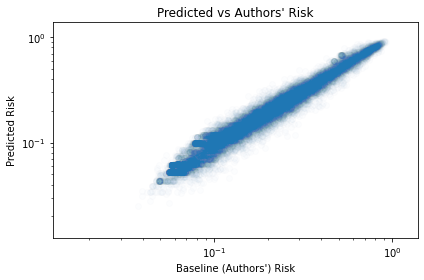

R2: 0.9619287896594549


In [ ]:
# Compare Risk Scores for full GBC model
risk__gbc_combined_baseline = pd.merge(
    gbc_risk, 
    baseline_risk_scores, 
    how='inner', 
    left_index=True, 
    right_index=True,
    suffixes=('', '_baseline')
    )
plot_compare_baseline(
    data=risk__gbc_combined_baseline,
    baseline_colname='Frisk',
    pred_colname='Risk',
    # log_scales=False,
    alpha=0.01
    )

## Test 2 – Random Forest

Try Random Forests (note: CV runs a while. I put the best params in next cell if u wanna skip)

In [ ]:
# Get best params by CV
rf = RandomForestClassifier()
param_grid = {
    'max_depth': [None, 100, 110, 120],
    'min_samples_leaf': [1, 3, 4],
    'min_samples_split': [2, 8, 10, 12],
    'n_estimators': [100, 200, 300]
}
gridsearcher = GridSearchCV(rf, param_grid=param_grid, cv = 5, n_jobs = -1, verbose = 2)
#gridsearcher.fit(X_train, y_train) 
#print(gridsearcher.best_params_)

Doing RandomForestClassifier: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


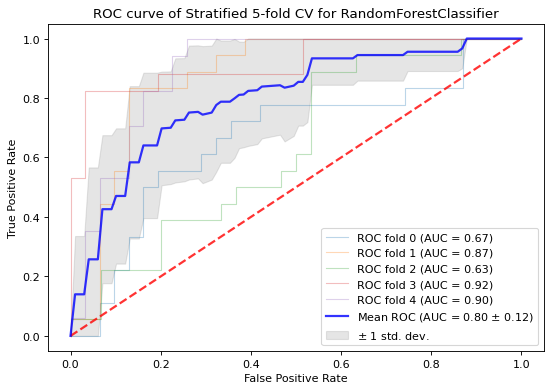

In [ ]:
params = {'max_depth': 110,
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 100} #gridsearcher.best_params_
 
rf_trainer = Trainer(
  model=RandomForestClassifier(**params),
  X_train=X_train, 
  y_train=y_train,
  X_test=all_genes
)
rf_trainer.do_train()
rf_feats_cv, rf_risk_cv = rf_trainer.predict_cv()
rf_feats, rf_risk = rf_trainer.predict()

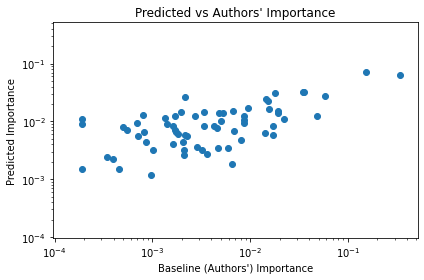

R2: 0.34868519124180897


In [ ]:
# Compare Feature Importance for full RF model
feats__rf_combined_baseline = pd.merge(
    rf_feats, 
    baseline_feature_importance, 
    how='inner', 
    left_on='Cell Type', 
    right_index=True,
    suffixes=('', '_baseline')
    )

plot_compare_baseline(data=feats__rf_combined_baseline)

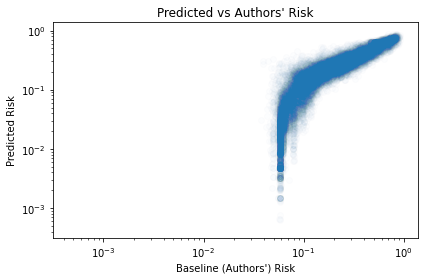

R2: 0.8498029844436528


In [ ]:
# Compare Risk Scores for full RF model
risk__rf_combined_baseline = pd.merge(
    rf_risk, 
    baseline_risk_scores, 
    how='inner', 
    left_index=True, 
    right_index=True,
    suffixes=('', '_baseline')
    )
plot_compare_baseline(
    data=risk__rf_combined_baseline,
    baseline_colname='Frisk',
    pred_colname='Risk',
    alpha=0.01
    )



```
# This is formatted as code
```

# Test 3: augmenting data and re-running ROC / A-Risk Scores

In [ ]:
all_genes_week = all_genes.copy()
# y_train_week = train_week['label']
# all_genes_week = train_week.drop(columns='label')

# Report shapes
print(f'The training set consists of: \n - {all_genes_week.shape[0]} samples (genes)')

# preview 
print(all_genes_week.shape)
all_genes_week.head()

The training set consists of: 
 - 17740 samples (genes)
(17740, 95)


,hRgl2a_7,hProgBP_7,hOMTN_7,hRgl2a_9,hNProg_9,hProgBP_9,hOMTN_9,hDA0_9,hNbM_9,hNbML5_9,hDA1_9,hGaba_9,hDA2_9,hNbGaba_9,hRgl2a_10,hDA0_10,hNbM_10,hEndo_10,hRgl2b_10,hRgl3_10,hPeric_10,hDA1_10,hRgl1_10,hDA2_10,hRgl2a_11,hEndo_11,hRgl2b_11,hRgl3_11,hPeric_11,hRgl2c_11,hOPC_11,hNProg_6,hProgBP_6,hProgM_6,hOMTN_6,hProgFPL_6,hProgFPM_6,hNbML1_6,hNProg_8,hProgBP_8,...,OPCs_2_GW23,exneurons_5_GW19,exneurons_6_GW19,exneurons_7_GW19,astrocytes_1_GW26,astrocytes_3_GW26,exneurons_5_GW26,exneurons_6_GW26,exneurons_7_GW26,interneurons_5_GW26,interneurons_6_GW26,interneurons_2_GW26,interneurons_4_GW26,interneurons_7_GW26,interneurons_8_GW26,microglia_2_GW26,OPCs_2_GW26,OPCs_3_GW26,OPCs_1_GW26,exneurons_1_GW8,exneurons_1_GW10,NPCs_6_GW10,NPCs_1_GW10,NPCs_5_GW10,exneurons_2_GW12,exneurons_1_GW9,NPCs_1_GW9,exneurons_5_GW16,exneurons_4_GW16,exneurons_3_GW16,interneurons_6_GW16,interneurons_2_GW16,interneurons_7_GW16,interneurons_8_GW16,NPCs_3_GW16,NPCs_6_GW16,NPCs_8_GW16,NPCs_7_GW16,NPCs_9_GW16,OPCs_2_GW16
DDX11L1,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,0.047619,0.066667,0.000000,0.000000,0.000000,0.043478,0.000000,0.000,0.01,0.0000,0.000000,0.000000,0.000000,0.000000,0.017391,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.00,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
LOC101928626,0.000000,0.0625,0.058824,0.0,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.076923,0.043478,0.000000,0.000,0.05,0.0000,0.000000,0.083333,0.111111,0.095238,0.165217,0.111111,0.117647,0.047619,0.0375,0.046512,0.062500,0.12,0.140845,0.10,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.03125,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
LINC00115,0.000000,0.0000,0.058824,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000,0.02,0.0625,0.105263,0.000000,0.055556,0.095238,0.008696,0.055556,0.058824,0.047619,0.0375,0.069767,0.083333,0.08,0.056338,0.05,0.190476,0.037037,0.043478,0.027027,0.115385,0.029412,0.017544,0.083333,0.069767,0.00000,...,0.181818,0.000000,0.000000,0.029412,0.184211,0.1250,0.000000,0.133333,0.057692,0.000000,0.00,0.058824,0.026316,0.025,0.101449,0.055556,0.066667,0.000000,0.157895,0.142857,0.056180,0.000000,0.00,0.046512,0.056604,0.029412,0.00,0.079812,0.102857,0.117241,0.058824,0.000000,0.0625,0.055556,0.121212,0.10,0.058824,0.272727,0.111111,0.000000
LINC01128,0.058824,0.1875,0.117647,0.0,0.076923,0.111111,0.238095,0.066667,0.333333,0.172414,0.230769,0.152174,0.083333,0.125,0.07,0.0625,0.263158,0.166667,0.055556,0.000000,0.130435,0.055556,0.058824,0.000000,0.0875,0.116279,0.145833,0.20,0.211268,0.15,0.047619,0.037037,0.130435,0.135135,0.192308,0.058824,0.035088,0.083333,0.093023,0.12500,...,0.090909,0.250000,0.259259,0.147059,0.263158,0.4375,0.214286,0.177778,0.115385,0.083333,0.04,0.058824,0.157895,0.225,0.386473,0.222222,0.233333,0.133333,0.263158,0.285714,0.235955,0.333333,0.25,0.302326,0.132075,0.205882,0.08,0.206573,0.297143,0.358621,0.176471,0.416667,0.1875,0.333333,0.363636,0.15,0.352941,0.500000,0.296296,0.166667
FAM41C,0.000000,0.0000,0.000000,0.0,0.076923,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000,0.00,0.0625,0.000000,0.000000,0.055556,0.000000,0.008696,0.055556,0.000000,0.000000,0.0250,0.000000,0.000000,0.00,0.014085,0.00,0.000000,

In [ ]:
columns = []
for col in range(len(all_genes_week.columns)):
  col_split = all_genes_week.columns[col].split('_')
  if len(col_split) == 2:
    if col_split[0] not in columns:
      columns.append(col_split[0])
  else:
    if col_split[0] + '_' + col_split[2] not in columns:
      columns.append(col_split[0] + '_' + col_split[2])
print(len(columns))

42


In [ ]:
from math import nan
all_cols = all_genes_week.columns
temp_df_cols = []
for colname in columns:
  splitting_columns = []
  col_split = colname.split('_')
  if len(col_split) == 1:
    for week_num in range(1, 13):
      temp_col = col_split[0] + '_' + str(week_num)
      splitting_columns.append(temp_col)
      if temp_col not in all_cols:
        all_genes_week[temp_col] = np.nan
  else:
    for week_num in range(1, 13):
      temp_col = col_split[0] + '_' + str(week_num) + '_' + col_split[1]
      splitting_columns.append(temp_col)
      if temp_col not in all_cols:
        all_genes_week[temp_col] = np.nan
  temp_df_cols.append(splitting_columns)
all_genes_week.head()

,hRgl2a_7,hProgBP_7,hOMTN_7,hRgl2a_9,hNProg_9,hProgBP_9,hOMTN_9,hDA0_9,hNbM_9,hNbML5_9,hDA1_9,hGaba_9,hDA2_9,hNbGaba_9,hRgl2a_10,hDA0_10,hNbM_10,hEndo_10,hRgl2b_10,hRgl3_10,hPeric_10,hDA1_10,hRgl1_10,hDA2_10,hRgl2a_11,hEndo_11,hRgl2b_11,hRgl3_11,hPeric_11,hRgl2c_11,hOPC_11,hNProg_6,hProgBP_6,hProgM_6,hOMTN_6,hProgFPL_6,hProgFPM_6,hNbML1_6,hNProg_8,hProgBP_8,...,NPCs_8_GW9,NPCs_9_GW9,NPCs_10_GW9,NPCs_11_GW9,NPCs_12_GW9,exneurons_1_GW16,exneurons_2_GW16,exneurons_6_GW16,exneurons_7_GW16,exneurons_8_GW16,exneurons_9_GW16,exneurons_10_GW16,exneurons_11_GW16,exneurons_12_GW16,interneurons_1_GW16,interneurons_3_GW16,interneurons_4_GW16,interneurons_5_GW16,interneurons_9_GW16,interneurons_10_GW16,interneurons_11_GW16,interneurons_12_GW16,NPCs_1_GW16,NPCs_2_GW16,NPCs_4_GW16,NPCs_5_GW16,NPCs_10_GW16,NPCs_11_GW16,NPCs_12_GW16,OPCs_1_GW16,OPCs_3_GW16,OPCs_4_GW16,OPCs_5_GW16,OPCs_6_GW16,OPCs_7_GW16,OPCs_8_GW16,OPCs_9_GW16,OPCs_10_GW16,OPCs_11_GW16,OPCs_12_GW16
DDX11L1,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,0.047619,0.066667,0.000000,0.000000,0.000000,0.043478,0.000000,0.000,0.01,0.0000,0.000000,0.000000,0.000000,0.000000,0.017391,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.00,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LOC101928626,0.000000,0.0625,0.058824,0.0,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.076923,0.043478,0.000000,0.000,0.05,0.0000,0.000000,0.083333,0.111111,0.095238,0.165217,0.111111,0.117647,0.047619,0.0375,0.046512,0.062500,0.12,0.140845,0.10,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.03125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LINC00115,0.000000,0.0000,0.058824,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000,0.02,0.0625,0.105263,0.000000,0.055556,0.095238,0.008696,0.055556,0.058824,0.047619,0.0375,0.069767,0.083333,0.08,0.056338,0.05,0.190476,0.037037,0.043478,0.027027,0.115385,0.029412,0.017544,0.083333,0.069767,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LINC01128,0.058824,0.1875,0.117647,0.0,0.076923,0.111111,0.238095,0.066667,0.333333,0.172414,0.230769,0.152174,0.083333,0.125,0.07,0.0625,0.263158,0.166667,0.055556,0.000000,0.130435,0.055556,0.058824,0.000000,0.0875,0.116279,0.145833,0.20,0.211268,0.15,0.047619,0.037037,0.130435,0.135135,0.192308,0.058824,0.035088,0.083333,0.093023,0.12500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAM41C,0.000000,0.0000,0.000000,0.0,0.076923,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000,0.00,0.0625,0.000000,0.000000,0.055556,0.000000,0.008696,0.055556,0.000000,0.000000,0.0250,0.000000,0.000000,0.00,0.014085,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for col_sets in temp_df_cols:
  temp_df = all_genes_week[col_sets]
  all_genes_week.drop(col_sets, axis = 1)
  pd.set_option('display.max_columns', None)
  temp_df = temp_df.T
  # define imputer
  imputer = KNNImputer()
  # fit on the dataset
  X_new = imputer.fit_transform(temp_df)
  # transform the dataset
  X_new = np.transpose(X_new)
  all_genes_week[col_sets] = X_new

In [ ]:
all_genes_week.isnull().values.any()

False

In [ ]:
print(all_genes_week.shape)
all_genes_week.head()

(17740, 504)


,hRgl2a_7,hProgBP_7,hOMTN_7,hRgl2a_9,hNProg_9,hProgBP_9,hOMTN_9,hDA0_9,hNbM_9,hNbML5_9,hDA1_9,hGaba_9,hDA2_9,hNbGaba_9,hRgl2a_10,hDA0_10,hNbM_10,hEndo_10,hRgl2b_10,hRgl3_10,hPeric_10,hDA1_10,hRgl1_10,hDA2_10,hRgl2a_11,hEndo_11,hRgl2b_11,hRgl3_11,hPeric_11,hRgl2c_11,hOPC_11,hNProg_6,hProgBP_6,hProgM_6,hOMTN_6,hProgFPL_6,hProgFPM_6,hNbML1_6,hNProg_8,hProgBP_8,hProgM_8,hOMTN_8,hNbM_8,hProgFPL_8,hProgFPM_8,hRN_8,hNbML1_8,exneurons_6_GW23,exneurons_7_GW23,interneurons_2_GW23,interneurons_4_GW23,interneurons_3_GW23,interneurons_1_GW23,interneurons_7_GW23,interneurons_8_GW23,OPCs_2_GW23,exneurons_5_GW19,exneurons_6_GW19,exneurons_7_GW19,astrocytes_1_GW26,astrocytes_3_GW26,exneurons_5_GW26,exneurons_6_GW26,exneurons_7_GW26,interneurons_5_GW26,interneurons_6_GW26,interneurons_2_GW26,interneurons_4_GW26,interneurons_7_GW26,interneurons_8_GW26,microglia_2_GW26,OPCs_2_GW26,OPCs_3_GW26,OPCs_1_GW26,exneurons_1_GW8,exneurons_1_GW10,NPCs_6_GW10,NPCs_1_GW10,NPCs_5_GW10,exneurons_2_GW12,exneurons_1_GW9,NPCs_1_GW9,exneurons_5_GW16,exneurons_4_GW16,exneurons_3_GW16,interneurons_6_GW16,interneurons_2_GW16,interneurons_7_GW16,interneurons_8_GW16,NPCs_3_GW16,NPCs_6_GW16,NPCs_8_GW16,NPCs_7_GW16,NPCs_9_GW16,OPCs_2_GW16,hRgl2a_1,hRgl2a_2,hRgl2a_3,hRgl2a_4,hRgl2a_5,hRgl2a_6,hRgl2a_8,hRgl2a_12,hProgBP_1,hProgBP_2,hProgBP_3,hProgBP_4,hProgBP_5,hProgBP_10,hProgBP_11,hProgBP_12,hOMTN_1,hOMTN_2,hOMTN_3,hOMTN_4,hOMTN_5,hOMTN_10,hOMTN_11,hOMTN_12,hNProg_1,hNProg_2,hNProg_3,hNProg_4,hNProg_5,hNProg_7,hNProg_10,hNProg_11,hNProg_12,hDA0_1,hDA0_2,hDA0_3,hDA0_4,hDA0_5,hDA0_6,hDA0_7,hDA0_8,hDA0_11,hDA0_12,hNbM_1,hNbM_2,hNbM_3,hNbM_4,hNbM_5,hNbM_6,hNbM_7,hNbM_11,hNbM_12,hNbML5_1,hNbML5_2,hNbML5_3,hNbML5_4,hNbML5_5,hNbML5_6,hNbML5_7,hNbML5_8,hNbML5_10,hNbML5_11,hNbML5_12,hDA1_1,hDA1_2,hDA1_3,hDA1_4,hDA1_5,hDA1_6,hDA1_7,hDA1_8,hDA1_11,hDA1_12,hGaba_1,hGaba_2,hGaba_3,hGaba_4,hGaba_5,hGaba_6,hGaba_7,hGaba_8,hGaba_10,hGaba_11,hGaba_12,hDA2_1,hDA2_2,hDA2_3,hDA2_4,hDA2_5,hDA2_6,hDA2_7,hDA2_8,hDA2_11,hDA2_12,hNbGaba_1,hNbGaba_2,hNbGaba_3,hNbGaba_4,hNbGaba_5,hNbGaba_6,hNbGaba_7,hNbGaba_8,hNbGaba_10,hNbGaba_11,hNbGaba_12,hEndo_1,hEndo_2,hEndo_3,hEndo_4,hEndo_5,hEndo_6,hEndo_7,hEndo_8,hEndo_9,hEndo_12,hRgl2b_1,hRgl2b_2,hRgl2b_3,hRgl2b_4,hRgl2b_5,hRgl2b_6,hRgl2b_7,hRgl2b_8,hRgl2b_9,hRgl2b_12,hRgl3_1,hRgl3_2,hRgl3_3,hRgl3_4,hRgl3_5,hRgl3_6,hRgl3_7,hRgl3_8,hRgl3_9,hRgl3_12,hPeric_1,hPeric_2,hPeric_3,hPeric_4,hPeric_5,hPeric_6,hPeric_7,hPeric_8,hPeric_9,hPeric_12,hRgl1_1,hRgl1_2,hRgl1_3,hRgl1_4,hRgl1_5,hRgl1_6,hRgl1_7,hRgl1_8,hRgl1_9,hRgl1_11,hRgl1_12,hRgl2c_1,hRgl2c_2,hRgl2c_3,hRgl2c_4,hRgl2c_5,hRgl2c_6,hRgl2c_7,hRgl2c_8,hRgl2c_9,hRgl2c_10,hRgl2c_12,hOPC_1,hOPC_2,hOPC_3,hOPC_4,hOPC_5,hOPC_6,hOPC_7,hOPC_8,hOPC_9,hOPC_10,hOPC_12,hProgM_1,hProgM_2,hProgM_3,hProgM_4,hProgM_5,hProgM_7,hProgM_9,hProgM_10,hProgM_11,hProgM_12,hProgFPL_1,hProgFPL_2,hProgFPL_3,hProgFPL_4,hProgFPL_5,hProgFPL_7,hProgFPL_9,hProgFPL_10,hProgFPL_11,hProgFPL_12,hProgFPM_1,hProgFPM_2,hProgFPM_3,hProgFPM_4,hProgFPM_5,hProgFPM_7,hProgFPM_9,hProgFPM_10,hProgFPM_11,hProgFPM_12,hNbML1_1,hNbML1_2,hNbML1_3,hNbML1_4,hNbML1_5,hNbML1_7,hNbML1_9,hNbML1_10,hNbML1_11,hNbML1_12,hRN_1,hRN_2,hRN_3,hRN_4,hRN_5,hRN_6,hRN_7,hRN_9,hRN_10,hRN_11,hRN_12,exneurons_1_GW23,exneurons_2_GW23,exneurons_3_GW23,exneurons_4_GW23,exneurons_5_GW23,exneurons_8_GW23,exneurons_9_GW23,exneurons_10_GW23,exneurons_11_GW23,exneurons_12_GW23,interneurons_5_GW23,interneurons_6_GW23,interneurons_9_GW23,interneurons_10_GW23,interneurons_11_GW23,interneurons_12_GW23,OPCs_1_GW23,OPCs_3_GW23,OPCs_4_GW23,OPCs_5_GW23,OPCs_6_GW23,OPCs_7_GW23,OPCs_8_GW23,OPCs_9_GW23,OPCs_10_GW23,OPCs_11_GW23,OPCs_12_GW23,exneurons_1_GW19,exneurons_2_GW19,exneurons_3_GW19,exneurons_4_GW19,exneurons_8_GW19,exneurons_9_GW19,exneurons_10_GW19,exneurons_11_GW19,exneurons_12_GW19,astrocytes_2_GW26,astrocytes_4_GW26,astrocytes_5_GW26,astrocytes_6_GW26,astrocytes_7_GW26,astrocytes_8_GW26,astrocytes_9_GW26,astrocytes_10_GW26,astrocytes_11_GW26,astrocytes_12_GW26,exneurons_1_GW26,exneurons_

In [ ]:
# Filter to get the y_pos and y_neg (training data precursor)
y_pos_week = all_genes_week.loc[all_genes_week.index.intersection(autism_data['gene.symbol']),]
y_neg_week = all_genes_week.loc[all_genes_week.index.intersection(control_data['GeneName']), ]

# Make sure there is no overlap of genes in y_pos and y_neg
y_neg_week = y_neg_week.drop(index=y_pos_week.index.intersection(y_neg_week.index))

# Add 'labels' column
y_pos_week['label'] = 1
y_neg_week['label'] = 0

# Report shapes
print(f'Shape of y_pos: {y_pos_week.shape}')
print(f'Shape of y_neg: {y_neg_week.shape}')

Shape of y_pos: (88, 505)
Shape of y_neg: (154, 505)


In [ ]:
# Construct Training Set
train_week = pd.concat([y_pos_week, y_neg_week])
y_train_week = train_week['label']
X_train_week = train_week.drop(columns='label')

# Report shapes
print(f'The training set consists of: \n - {train_week.shape[0]} samples (genes) <- {y_pos_week.shape[0]} positives and {y_neg_week.shape[0]} negatives, \n - {X_train_week.shape[1]} features (expression by cell type*time)')

# preview 
train_week[['label', *train_week.columns]].head()

The training set consists of: 
 - 242 samples (genes) <- 88 positives and 154 negatives, 
 - 504 features (expression by cell type*time)


,label,hRgl2a_7,hProgBP_7,hOMTN_7,hRgl2a_9,hNProg_9,hProgBP_9,hOMTN_9,hDA0_9,hNbM_9,hNbML5_9,hDA1_9,hGaba_9,hDA2_9,hNbGaba_9,hRgl2a_10,hDA0_10,hNbM_10,hEndo_10,hRgl2b_10,hRgl3_10,hPeric_10,hDA1_10,hRgl1_10,hDA2_10,hRgl2a_11,hEndo_11,hRgl2b_11,hRgl3_11,hPeric_11,hRgl2c_11,hOPC_11,hNProg_6,hProgBP_6,hProgM_6,hOMTN_6,hProgFPL_6,hProgFPM_6,hNbML1_6,hNProg_8,hProgBP_8,hProgM_8,hOMTN_8,hNbM_8,hProgFPL_8,hProgFPM_8,hRN_8,hNbML1_8,exneurons_6_GW23,exneurons_7_GW23,interneurons_2_GW23,interneurons_4_GW23,interneurons_3_GW23,interneurons_1_GW23,interneurons_7_GW23,interneurons_8_GW23,OPCs_2_GW23,exneurons_5_GW19,exneurons_6_GW19,exneurons_7_GW19,astrocytes_1_GW26,astrocytes_3_GW26,exneurons_5_GW26,exneurons_6_GW26,exneurons_7_GW26,interneurons_5_GW26,interneurons_6_GW26,interneurons_2_GW26,interneurons_4_GW26,interneurons_7_GW26,interneurons_8_GW26,microglia_2_GW26,OPCs_2_GW26,OPCs_3_GW26,OPCs_1_GW26,exneurons_1_GW8,exneurons_1_GW10,NPCs_6_GW10,NPCs_1_GW10,NPCs_5_GW10,exneurons_2_GW12,exneurons_1_GW9,NPCs_1_GW9,exneurons_5_GW16,exneurons_4_GW16,exneurons_3_GW16,interneurons_6_GW16,interneurons_2_GW16,interneurons_7_GW16,interneurons_8_GW16,NPCs_3_GW16,NPCs_6_GW16,NPCs_8_GW16,NPCs_7_GW16,NPCs_9_GW16,OPCs_2_GW16,hRgl2a_1,hRgl2a_2,hRgl2a_3,hRgl2a_4,hRgl2a_5,hRgl2a_6,hRgl2a_8,hRgl2a_12,hProgBP_1,hProgBP_2,hProgBP_3,hProgBP_4,hProgBP_5,hProgBP_10,hProgBP_11,hProgBP_12,hOMTN_1,hOMTN_2,hOMTN_3,hOMTN_4,hOMTN_5,hOMTN_10,hOMTN_11,hOMTN_12,hNProg_1,hNProg_2,hNProg_3,hNProg_4,hNProg_5,hNProg_7,hNProg_10,hNProg_11,hNProg_12,hDA0_1,hDA0_2,hDA0_3,hDA0_4,hDA0_5,hDA0_6,hDA0_7,hDA0_8,hDA0_11,hDA0_12,hNbM_1,hNbM_2,hNbM_3,hNbM_4,hNbM_5,hNbM_6,hNbM_7,hNbM_11,hNbM_12,hNbML5_1,hNbML5_2,hNbML5_3,hNbML5_4,hNbML5_5,hNbML5_6,hNbML5_7,hNbML5_8,hNbML5_10,hNbML5_11,hNbML5_12,hDA1_1,hDA1_2,hDA1_3,hDA1_4,hDA1_5,hDA1_6,hDA1_7,hDA1_8,hDA1_11,hDA1_12,hGaba_1,hGaba_2,hGaba_3,hGaba_4,hGaba_5,hGaba_6,hGaba_7,hGaba_8,hGaba_10,hGaba_11,hGaba_12,hDA2_1,hDA2_2,hDA2_3,hDA2_4,hDA2_5,hDA2_6,hDA2_7,hDA2_8,hDA2_11,hDA2_12,hNbGaba_1,hNbGaba_2,hNbGaba_3,hNbGaba_4,hNbGaba_5,hNbGaba_6,hNbGaba_7,hNbGaba_8,hNbGaba_10,hNbGaba_11,hNbGaba_12,hEndo_1,hEndo_2,hEndo_3,hEndo_4,hEndo_5,hEndo_6,hEndo_7,hEndo_8,hEndo_9,hEndo_12,hRgl2b_1,hRgl2b_2,hRgl2b_3,hRgl2b_4,hRgl2b_5,hRgl2b_6,hRgl2b_7,hRgl2b_8,hRgl2b_9,hRgl2b_12,hRgl3_1,hRgl3_2,hRgl3_3,hRgl3_4,hRgl3_5,hRgl3_6,hRgl3_7,hRgl3_8,hRgl3_9,hRgl3_12,hPeric_1,hPeric_2,hPeric_3,hPeric_4,hPeric_5,hPeric_6,hPeric_7,hPeric_8,hPeric_9,hPeric_12,hRgl1_1,hRgl1_2,hRgl1_3,hRgl1_4,hRgl1_5,hRgl1_6,hRgl1_7,hRgl1_8,hRgl1_9,hRgl1_11,hRgl1_12,hRgl2c_1,hRgl2c_2,hRgl2c_3,hRgl2c_4,hRgl2c_5,hRgl2c_6,hRgl2c_7,hRgl2c_8,hRgl2c_9,hRgl2c_10,hRgl2c_12,hOPC_1,hOPC_2,hOPC_3,hOPC_4,hOPC_5,hOPC_6,hOPC_7,hOPC_8,hOPC_9,hOPC_10,hOPC_12,hProgM_1,hProgM_2,hProgM_3,hProgM_4,hProgM_5,hProgM_7,hProgM_9,hProgM_10,hProgM_11,hProgM_12,hProgFPL_1,hProgFPL_2,hProgFPL_3,hProgFPL_4,hProgFPL_5,hProgFPL_7,hProgFPL_9,hProgFPL_10,hProgFPL_11,hProgFPL_12,hProgFPM_1,hProgFPM_2,hProgFPM_3,hProgFPM_4,hProgFPM_5,hProgFPM_7,hProgFPM_9,hProgFPM_10,hProgFPM_11,hProgFPM_12,hNbML1_1,hNbML1_2,hNbML1_3,hNbML1_4,hNbML1_5,hNbML1_7,hNbML1_9,hNbML1_10,hNbML1_11,hNbML1_12,hRN_1,hRN_2,hRN_3,hRN_4,hRN_5,hRN_6,hRN_7,hRN_9,hRN_10,hRN_11,hRN_12,exneurons_1_GW23,exneurons_2_GW23,exneurons_3_GW23,exneurons_4_GW23,exneurons_5_GW23,exneurons_8_GW23,exneurons_9_GW23,exneurons_10_GW23,exneurons_11_GW23,exneurons_12_GW23,interneurons_5_GW23,interneurons_6_GW23,interneurons_9_GW23,interneurons_10_GW23,interneurons_11_GW23,interneurons_12_GW23,OPCs_1_GW23,OPCs_3_GW23,OPCs_4_GW23,OPCs_5_GW23,OPCs_6_GW23,OPCs_7_GW23,OPCs_8_GW23,OPCs_9_GW23,OPCs_10_GW23,OPCs_11_GW23,OPCs_12_GW23,exneurons_1_GW19,exneurons_2_GW19,exneurons_3_GW19,exneurons_4_GW19,exneurons_8_GW19,exneurons_9_GW19,exneurons_10_GW19,exneurons_11_GW19,exneurons_12_GW19,astrocytes_2_GW26,astrocytes_4_GW26,astrocytes_5_GW26,astrocytes_6_GW26,astrocytes_7_GW26,astrocytes_8_GW26,astrocytes_9_GW26,astrocytes_10_GW26,astrocytes_11_GW26,astrocytes_12_GW26,exneurons_1_GW26,exne

In [ ]:
# Construct Test Data (but no labels)
X_test_week = all_genes_week.drop(index=train_week.index)
X_test_week.shape

(17498, 504)

Doing GradientBoostingClassifier: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


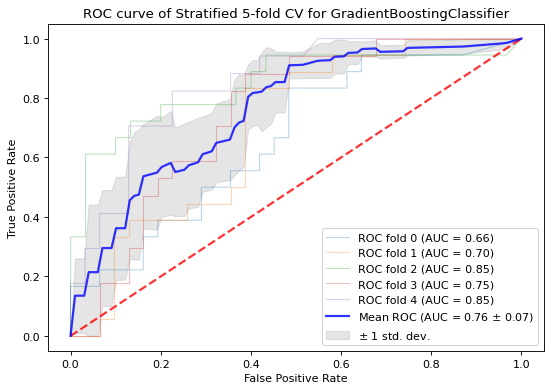

In [ ]:
params = {
  'n_estimators': 300,
  'learning_rate': 0.05, 
  'max_depth': 1, 
  'random_state': 7
}

newmodel = GradientBoostingClassifier(**params)

gbc_trainer_new = Trainer(
  model=newmodel,
  X_train=X_train_week, 
  y_train=y_train_week,
  X_test=all_genes_week
)
gbc_trainer_new.do_train()
gbc_feats_cv_week, gbc_risk_cv_week = gbc_trainer_new.predict_cv()
gbc_feats_week, gbc_risk_week = gbc_trainer_new.predict()

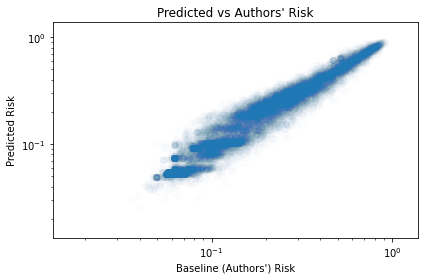

R2: 0.9459739286777618


In [52]:
#Compare A-Risk scores of Gradient Boosting on Original Dataset with augmented dataset
risk_ = pd.merge(
    gbc_risk_week, 
    baseline_risk_scores, 
    how='inner', 
    left_index=True, 
    right_index=True,
    suffixes=('', '_baseline')
    )
plot_compare_baseline(
    data=risk_,
    baseline_colname='Frisk',
    pred_colname='Risk',
    alpha=0.01
    )

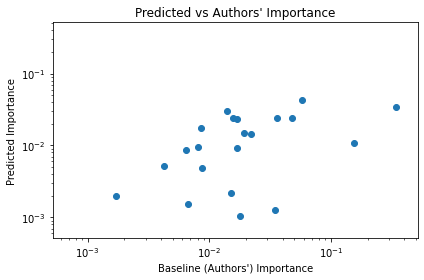

R2: -0.011437040275642074


In [ ]:
#Compare Feature Importance of Gradient Boosting on Original Dataset with Augment Dataset
feats__rf_combined_baseline = pd.merge(
    gbc_feats_week, 
    baseline_feature_importance, 
    how='inner', 
    left_on='Cell Type', 
    right_index=True,
    suffixes=('', '_baseline')
    )

plot_compare_baseline(data=feats__rf_combined_baseline)